# Exporting various details of topics models

In [1]:
%load_ext autoreload
%autoreload 2

import nlp
import json

import numpy as np

from sklearn import manifold
from sklearn.preprocessing import MinMaxScaler
    
from gensim.models.ldamodel import LdaModel

import matplotlib.pyplot as plt
%matplotlib inline 

### Load and clean the data

In [2]:
data = nlp.load_file('../data/lee.txt')
docs = nlp.preprocess(data)
len(data), data[0], docs[0]

(300,
 'Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are availabl

### Compute color of terms using word2vec

In [3]:
word2vec = nlp.build_word2vec(docs)
wordvecs = word2vec.wv

We can apply t-sne projection to show all terms in the dictionary.

In [4]:
matrix = np.concatenate([wordvecs[t].reshape(1, -1) for t in wordvecs.vocab])
coords = manifold.TSNE(perplexity=100, random_state=0).fit_transform(matrix)

We use coordinates from t-sne projection to map terms to a color wheel.

In [5]:
import colorsys

def angle_between(v1, v2):
    return np.arccos(np.dot(v1, v2) / (np.linalg.norm(v1) * (np.linalg.norm(v2))))

def get_h(x, y):
    a = angle_between((x, y), (1, 0)) / np.pi / 2
    return a if y >= 0 else 1 - a

def get_max_xy(points):
    'Fit the points into a circle, centering at (0, 0). Return the radius of the circle.'
    return max(np.linalg.norm(p) for p in points)

def get_s(x, y, scale):
    return np.linalg.norm((x, y)) / scale
    
def get_2dcolor(points):
    max_xy = get_max_xy(points)
    return [colorsys.hls_to_rgb(get_h(*p), 0.5, get_s(*p, max_xy)) for p in points]

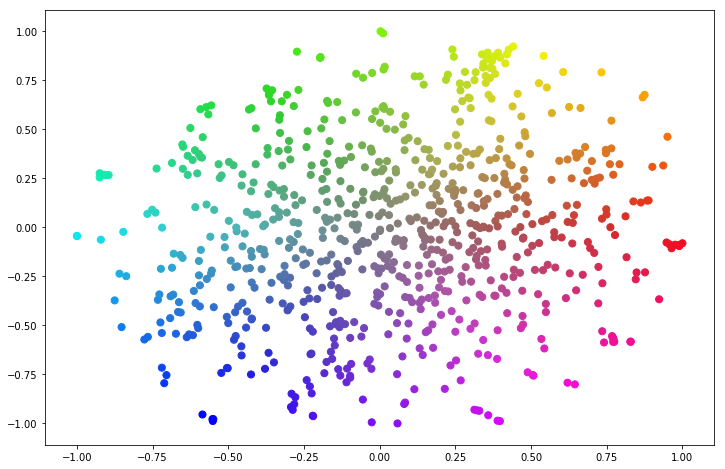

In [6]:
coords = MinMaxScaler(feature_range=(-1,1)).fit_transform(coords)
colors = get_2dcolor(coords)
plt.figure(figsize=(12,8))
plt.scatter(coords[:,0], coords[:,1], c=colors, s=50)
plt.show()

Store colors in a dictionary to lookup later.

In [7]:
terms = list(wordvecs.vocab.keys())
hex_colors = ['#{:02x}{:02x}{:02x}'.format(int(r * 255), int(g * 255), int(b * 255)) for r, g, b in colors]
color_lookup = {terms[i]:c for i, c in enumerate(hex_colors)} 

### Load computed models

In [8]:
alphas = [0.01, 0.1, 1, 10]
betas = [0.01, 0.1, 1, 10]
num_topics = [5, 10, 15, 20]
models = []

for a in alphas:
    for b in betas:
        for k in num_topics:
            model_id = '{}-{}-{}'.format(a, b, k)
            name = '../data/models/lee/' + model_id
            models.append({ 'modelId': model_id, 'lda': LdaModel.load(name) })

### Topic information
For each model: a list of { topicId, [word, prob, color] } for each topic, top 10 words.

In [9]:
def get_info_one_model(model):
    topics = nlp.get_topic_terms(model['lda'])
    for i in range(len(topics)):
        topics[i] = [(t, float(p), color_lookup[t]) for t, p in topics[i]]
        
    return topics

get_info_one_model(models[0])

[[('afghanistan', 0.027630120515823364, '#6329d5'),
  ('force', 0.022920889779925346, '#682dd1'),
  ('bin', 0.020877573639154434, '#4011ed'),
  ('laden', 0.017193827778100967, '#3f13eb'),
  ('qaeda', 0.015351959504187107, '#4e1ce2'),
  ('taliban', 0.015351803973317146, '#6725d9'),
  ('united', 0.014651277102530003, '#cd31ad'),
  ('afghan', 0.01442655734717846, '#792ed0'),
  ('state', 0.013025464490056038, '#c82ed0'),
  ('australian', 0.012724696658551693, '#ee5510')],
 [('fire', 0.02122757025063038, '#27d776'),
  ('south', 0.016302356496453285, '#44ba61'),
  ('people', 0.015280728228390217, '#51ad9f'),
  ('new', 0.014442957937717438, '#ca34c8'),
  ('sydney', 0.013002557680010796, '#30ce79'),
  ('child', 0.012951008975505829, '#d82665'),
  ('two', 0.012048723176121712, '#4d96b1'),
  ('area', 0.011020150035619736, '#2ed08d'),
  ('year', 0.010724515654146671, '#e5a919'),
  ('police', 0.010031570680439472, '#40b4be')],
 [('government', 0.019478008151054382, '#ad5192'),
  ('australia', 0.01

### Count information
We want to know how many documents in each topic and each pair of topics. So, we need a threshold for a topic probability to be consider as a *strong* topic of a document.

In [15]:
from collections import defaultdict
corpus, dictionary = nlp.build_corpus_dictionary(docs, min_count=10)

def get_count_one_model(model):
    doc_topics = [model['lda'].get_document_topics(doc, minimum_probability=0.2) for doc in corpus]
    num_topics = model['lda'].num_topics
    counts = defaultdict(int)
    
    for doc in doc_topics:
        topics = list(zip(*doc))
        if not topics:
            continue
            
        topics = topics[0]
        
        # Count each topic
        for i in range(num_topics):
            key = (i,)
            if i in topics:
                counts[key] += 1
                
        # Count pair of topics
        for i in range(num_topics):
            for j in range(i + 1, num_topics):
                key = (i, j)
                if i in topics and j in topics:
                    counts[key] += 1

    return list(dict(counts).items())

get_count_one_model(models[0])

[((1,), 110),
 ((3,), 54),
 ((2,), 128),
 ((2, 3), 15),
 ((0,), 60),
 ((0, 2), 16),
 ((4,), 75),
 ((1, 4), 20),
 ((1, 2), 36),
 ((0, 1), 11),
 ((0, 4), 3),
 ((0, 3), 7),
 ((2, 4), 21),
 ((1, 3), 6),
 ((3, 4), 4)]

### Export

In [17]:
def export_one_model(model):
    return { 'modelId': model['modelId'], 'topics': get_info_one_model(model), 'counts': get_count_one_model(model), 'corpusSize': len(docs) }

data = [export_one_model(model) for model in models]

with open('../data/lee-topics.json', 'w') as f:
    json.dump(data, f)